# Summary

The purpose of this project is to find patterns in unstructured text data and help answer the question "How much did the respondents learn from the online course?"

The notebook is broken into 4 sections: Preprocessing, Analysis, Predictive Modeling and Notes.

There were distinct patterns discovered in the data through unsupervised clustering and supervised classification. The patterns discovered were put into 6 Classes: Outlier (Class 0), Unintelligible Responses (Class 1), Low Info Responses (Class 2), Fair Responses (Class 3), Good Responses (Class 4) and Excellent Responses (Class 5).

To run the notebook, you will need 6 Excel files: the five files originally sent to me (Q1, Q2, Q3, Q4, Q5) and one I will provide (Text_Data_Updated). On the left side of this Colab notebook, you will see a small right-pointing arrow. Click that arrow to open the side menu. Then click Files within that menu. You'll then see an Upload button. Click Upload to upload all 5 files, then the notebook can be run.

If you need further explanation on any part of the project, please let me know.

In [0]:
# install pyspellchecker to find unintelligible responses
# install textstat to count words and assign Flesch reading ease & grade to responses
# install eli5 for permutation importances
# install wordcloud for word cloud diagram
!pip install pyspellchecker textstat eli5 wordcloud

     |████████████████████████████████| 1.9MB 4.7MB/s 
     |████████████████████████████████| 112kB 59.4MB/s 
     |████████████████████████████████| 3.0MB 40.5MB/s 


In [0]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from spellchecker import SpellChecker
import textstat
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import plotly.express as px
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


# Preprocessing

Read in data from the five Excel files and do some minor cleanup

In [0]:
# read in dataframes
q1 = pd.read_excel('Q1.xlsx', header=1, names=['Number', 'Response'])
q2 = pd.read_excel('Q2.xlsx', names=['Response'])
q3 = pd.read_excel('Q3.xlsx', names=['Response'])
q4 = pd.read_excel('Q4.xlsx', names=['Response'])
q5 = pd.read_excel('Q5.xlsx', names=['Response'])

# drop extra column in Q1
q1 = q1.drop(columns=['Number'])

# add column to each dataframe that includes question number
dfs = [q1, q2, q3, q4, q5]
q_count = 1
for df in dfs:
  df['Question'] = q_count
  q_count += 1

# concatenate all dataframes
df = pd.concat(dfs)

# drop all null values
df = df.dropna()

# reset index
df = df.reset_index().drop(columns=['index'])

Make a new column called Word_Count by using the lexicon_count function from the textstat library. This simply counts the number of words in a response. The word count will give us a better idea of how much effort the respondent put into their response.

In [0]:
# apply lexicon_count function
df['Word_Count'] = df['Response'].astype(str).apply(textstat.lexicon_count)

The function below will be used to clean the response to make the response more 'machine readable'. 

First, the function will break the response into tokens (i.e. comma separated list of words) so that we can deal with each word separately. 

Then the function removes all punctuation as it is the words themselves we're interested in. 

Then the function removes all characters that aren't alphabetic. Again, we are only interested in words.

But we're only interested in words that carry significat meaning. This brings us to the next section of the function. The function will remove 'stop words', which are usually very common words that don't carry a lot of meaning. Examples are 'the', 'a', 'an', etc. You'll see that I chose to keep some stop words because I thought they held enough meaning in this context to be useful. For example, I wanted to keep 'no' because that was a common response.

Next, the function turns all words to lowercase for uniformity. This part of the function also excludes words that are only 1 character long. Again, we only want words that convey significant meaning.

Finally, the function 'lemmatizes' each word to reduce it to its simplest form. This is so different forms of a word can be analyzed as a single term. For example, 'communications' would be changed to the singluar 'communication'.

In [0]:
# create lemmatizer instance
lemmatizer = WordNetLemmatizer()

# function that cleans responses
def clean_response(response):
  # tokenize the response
  tokens = str(response).split()

  # remove punctuation
  table = str.maketrans('', '', string.punctuation)
  tokens = [word.translate(table) for word in tokens]

  # remove non-alphabetic characters
  tokens = [word for word in tokens if word.isalpha()]

  # remove stop words
  stop_words = set(stopwords.words('english'))
  stopwords_to_keep = ['no', 'not', 'now', 'same', 'more']
  for stopword in stopwords_to_keep:
    stop_words.discard(stopword)
  tokens = [word for word in tokens if not word in stop_words]

  # make words lowercase, remove words one character in length
  tokens = [word.lower() for word in tokens if len(word) > 1]

  # lemmatize words
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  return tokens

# make new Response_Cleaned column by applying above function to Response Column
df['Response_Cleaned'] = df['Response'].apply(clean_response)

Below is a simple function that counts the cleaned response. I wanted to add this additional word count to add a little more context to the model. How many words are counted now that we've removed non-essential words?

In [0]:
# function to count the tokenized word list
def word_count_cleaned(word_list):
  return len(word_list)

# make new Word_Count_Cleaned column by applying the above function to the Response_Cleaned column
df['Word_Count_Cleaned'] = df['Response_Cleaned'].apply(word_count_cleaned)

There were many responses that were gibberish. So, the function below counts the number of words that were misspelled/unknown then divides that count by the total number of words in the response. I called this the Miscomprehension Percent.

In [0]:
# create SpellChecker instance
spell = SpellChecker()

# function that calculates the miscomprehension percent
def pct_of_nonwords(words_list):

  # start a try-except to bypass division by zero error
  try:

    # use spellchecker to identify which words are misspelled
    misspelled_words = list(spell.unknown(words_list))

    # use counter (starting at 0) to keep track of number of misspelled words
    misspell_count = 0

    # loop through list of misspelled words
    for mis in misspelled_words:

      # loop through all words
      for word in words_list:

        # if the misspelled word is in the words list, add 1 to the counter
        if mis == word:
          misspell_count += 1

    # divide misspelled count by total words
    nonword_pct = misspell_count / len(words_list)

  # if there is a division by zero error, return 1 (100%) miscomprehension percent
  except:
    nonword_pct = 1

  return nonword_pct

# make Miscomprehension_Pct column by applying the above function to Response_Cleaned column
df['Miscomprehension_Pct'] = df['Response_Cleaned'].apply(pct_of_nonwords)

The function below uses the Miscomprehension Percent to determine whether or not a response is unintelligible. I found that a Miscomprehension Percent above 70% caught all the unintelligible responses.

In [0]:
# simple function that identifies unintelligible responses
def unintelligible(miscomp_pct):
  if miscomp_pct > .7:
    return True
  else:
    return False

# make new Unintelligible_Response column by applying the above function to the Miscomprehension_Pct column
df['Unintelligible_Response'] = df['Miscomprehension_Pct'].apply(unintelligible)

Below a new column called Flesch_Kincaid_Grade is being made that uses the flesch_kincaid_grade function from the textstat library. We're using this function to gather more information on the complexity of the response. This grade is easy to interpret. For example, a grade of 9.3 means that a ninth grader would be able to read the document.

For a more in-depth view on this metric, visit this Wikipedia page on the subject:

https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch%E2%80%93Kincaid_grade_level

In [0]:
df['Flesch_Kincaid_Grade'] = df['Response'].astype(str).apply(textstat.flesch_kincaid_grade)

A new column called Flesch_Reading_Ease is being made below by applying the flesch_reading_ease function to the Response column. This metric is being used to add even more context about the complexity of the response. A high score mean the response was easy to read and a low score means the response was difficult to read. 

![](https://lh3.googleusercontent.com/broaSYuKWSgDp6GEcuVKd76Jt_AeHFi26vqRMyfs0uZV1FmTkvehJZ1oerWAb4uIEnj_bRXWw0dYOBlhkDpfKHFjt4gZD1_u5b0nGK8yZWAvSIzt-Cd_TFUf4IZLG08Y37IO5jce)

It's important to think about the context of this score. For example, for a blog that's trying to reach a large audience, one may want a high reading ease score. However, in a professional context, a lower score may indicate a more thorough response.

For more information on this metric, visit the same link above.

In [0]:
df['Flesch_Reading_Ease'] = df['Response'].astype(str).apply(textstat.flesch_reading_ease)

Below is a simple function to join the cleaned/tokenized responses back into one string. This will allow us to pass the responses to the Vectorizer model.

In [0]:
# function that goes through each cleaned response and joins the tokens together
def join_words(df):

  # empty list to store the joined respones
  responses = []

  # loop through each response in the dataframe
  for response in df['Response_Cleaned'].tolist():

    # joing the tokens with a space between them
    response = ' '.join(response)

    # append the joined responses to the list
    responses.append(response)

  return responses

# alter the Response_Cleaned column with the function above
df['Response_Cleaned'] = join_words(df)

Here we are previewing the preprocessing we've done so far.

In [0]:
# preview dataframe
df.head()

The function below uses the TfidfVectorizer to turn words into numbers. Tfidf stands for term frequency--inverse document frequency. 

Term Frequency (TF) is the total number of times a word appears in a response divided by the total number of words in a response.

Inverse Document Frequency (IDF) is the log of the total number of responses divided by the number of responses with a specific word in it.

To get the Tfidf weight, you simply multiply TF by IDF.

For a more in-depth look at the Tfidf Vectorizer method, check out this link:

http://www.tfidf.com/


In [0]:
def tfidf_words(df):

  # create TfidfVectorizer instance
  tfidf = TfidfVectorizer()

  #fit the cleaned response data to the tfidf object
  tfidf.fit(df['Response_Cleaned'])

  # transform the data into vectors
  tfidf_vectorized = tfidf.transform(df['Response_Cleaned'])

  # create dataframe with the vectors
  tfidf_vectorized_df = pd.DataFrame(tfidf_vectorized.toarray(), columns=tfidf.get_feature_names())

  # concatenate vectors dataframe with preprocessed dataframe
  df = pd.concat([df.reset_index().drop(columns=['index']), tfidf_vectorized_df], axis=1)

  return df

# apply above function to the main dataframe
df = tfidf_words(df)

Now let's preview the vectorized dataframe. You'll notice that the dimensionality (number of columns) has exploded. That's because there is now a single column for every word in the data.

In [0]:
df.head()

The function below makes latent semantic analysis (LSA) components. This is going to help us reduce the dimensionality of the data and let us visualize patterns within the data. LSA works similarly to the more popular dimension reduction, method principal component analysis (PCA). Basically, this algorithm will rotate the data in such a way where most of the variance (spread) will be along the x-axis, the second most variance will be along the y-axis, the third most variance will be along the z-axis and so on. Maximizing variance in this way helps us get the most information out of the dataset while using the fewest columns. One of the reasons this is so desirable is because it will allow us to visualize high-dimensional data.

To learn more about this method, check out this great interactive analysis of PCA:

http://setosa.io/ev/principal-component-analysis/

Remember, PCA is almost the same as LSA, but LSA is better for reducing the dimensionality of text data.

In [0]:
# function to reduce dimension
def make_lsa_components(df, n_components=3, n_iter=15, random_state=42):

  #make lsa instance with sklearn's TruncatedSVD
  lsa = TruncatedSVD(n_components=n_components, n_iter=n_iter, random_state=random_state)

  # select only numeric columns -- also remove question number here because the clusters become more interesting that way
  df_numeric = df.drop(columns=['Response', 'Response_Cleaned', 'Question'])

  # fit numeric data to lsa
  lsa.fit(df_numeric)

  # make dataframe with the LSA components, name columns depending on how many components selected
  lsa_df = pd.DataFrame(data=lsa.transform(df_numeric), 
                        columns=['LSA{}'.format(str(n)) for n in range(1, n_components+1)])

  return lsa_df

# make new dataframe of lsa components by applying above function to main dataframe
df_lsa = make_lsa_components(df)

Let's preview the LSA dataframe. Notice that these numbers and columns are difficult to interpret. This is the downside of unsupervised learning algorithms like LSA. But remember, the first column 'LSA1' represents the most variance within the dataset, 'LSA2' represents the second most variance and so on.

The important thing is that we can now visualize patterns within the data.

In [0]:
df_lsa.head()

,LSA1,LSA2,LSA3
0,-57.280457,-6.198146,-5.099784
1,-45.216772,5.004009,-7.233755
2,-35.798361,1.910183,-7.354630
3,-61.557077,11.089828,-6.157854
4,-63.152647,9.216173,-5.581770


To discover patterns within the data, we'll use an unsupervised method called K-means Clustering. 

To learn more about how this algorithm works, check out this informative analysis:

https://blog.easysol.net/machine-learning-algorithms-3/

In [0]:
# function that creates clusters
def kmeans_clusters(df_lsa, df, n_clusters=8, max_iter=1000, random_state=42):

  # make kmeans instance
  kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state)

  # fit LSA data to kmeans
  kmeans.fit(df_lsa)

  # make new Cluster column for df_lsa dataframe with the kmeans labels (clusters)
  df_lsa['Cluster'] = list(kmeans.labels_)

  # make new Cluster column for main dataframe with the kmeans labels (clusters)
  df['Cluster'] = list(kmeans.labels_)

  return df_lsa, df

# update LSA and main dataframes
df_lsa, df = kmeans_clusters(df_lsa, df)

In [0]:
# preview updated LSA data to see Cluster column
df_lsa.head()

,LSA1,LSA2,LSA3,Cluster
0,-57.280457,-6.198146,-5.099784,0
1,-45.216772,5.004009,-7.233755,4
2,-35.798361,1.910183,-7.354630,4
3,-61.557077,11.089828,-6.157854,0
4,-63.152647,9.216173,-5.581770,0


Now for the fun part. Let's look at the patterns within the data. Below is a 3D interactive plot. The different colors represent each cluster and the axes represent each LSA component.

If you have trouble viewing the plot, let me know. I have had issues with these plots before, but refreshing the notebook usually fixes the problem.

In [0]:
fig = px.scatter_3d(df_lsa, x='LSA1', y='LSA2', z='LSA3', color='Cluster')
fig.show()

Here's how many responses fall into each cluster.

In [0]:
df_lsa['Cluster'].value_counts()

0    5039
2    2925
4    2841
5    2480
1     608
7     133
6      72
3       5
Name: Cluster, dtype: int64

Also, make sure to consider the full dataset (with the clusters included) for coming up with ideas for further analysis.

In [0]:
df.head()

## Notes on Clustering:

You can use less clusters by changing the n_clusters parameter in the kmeans_clusters function above. I chose to use 8 because that's what seemed to break the data out into the most intuitive subsets. That made it easy to look through the data and see the patterns.

### Some interesting insights:

- All of the high-quality responses are clustered together.
- There are outlier responses (which I'll talk more about later) that were discovered through clustering. These outliers appear to be copy-paste responses.
- What I consider 'good' responses are clustered together for the most part.
- There are two clusters that had most of the 'low info' responses.
- There are two clusters that are a mix of 'fair' and 'low info' responses.
- Most of the unintelligible responses are in one cluster

#### At this point in the preprocessing, I saved the results to Excel spreadsheets (one spreadsheet for each cluster) and hand-labeled the responses for a more accurate classification. These classes will be used below for analysis and predictive modeling. The hand-labeling was made a lot easier by first doing the clustering.

# Analysis

Now that the data has been put into more intuitive classes, let's go over those classes.

## Classes:

#### 0 -- Outlier, answers appear to be copy-paste:
It looks like someone copy and pasted text from the questionnaire in for their response. This was detected by the clustering above.

#### 1 -- Unintelligible Response:
These responses are gibberish.

#### 2 -- Low Info Response, respondent addressed the question but provided minimal detail:
This is a very interesting class. This class is fairly ambiguous because it's very hard to tell how much the respondent gained from the training materials. For example, many respondents in this class say they can't properly answer the questions because they are new to the job, or that the question being asked is not relevant to their role, or they say there are no challenges (referring to Question 5) and don't provide any more information than that. Many responses in this class also may have some overlap with Class 3 because it was difficult to decide which class they belong to. In conclusion, this class needs further analysis.

#### 3 -- Fair Response, respondents provide some detail in response:
As stated above, there is some overlap between Class 2 and 3. Overall, Class 3's responses provide a bit more detail and, one could assume, a better grasp of the training material.

#### 4 -- Good Response:
These respondents put thought into their answers. Does that mean they gained the most from the material? That assumption likely needs more investigation. But these responses will provide the second most (to Class 5) information on what respondents think about the training.

#### 5 -- Excellent Response:
These respondents provided the most detail on the training. Does this mean these respondents gained the most from the training? Again, further analysis is likely required.

In [0]:
# read in class-updated dataframe (I will provide this in an Excel file)
new_df = pd.read_excel('Text_Data_Updated.xlsx').drop(columns=['Unnamed: 0'])

# preview data
new_df.head()

Let's look at how many responses fall into each class. As we might expect, most of the responses are in the middle of the distribution.

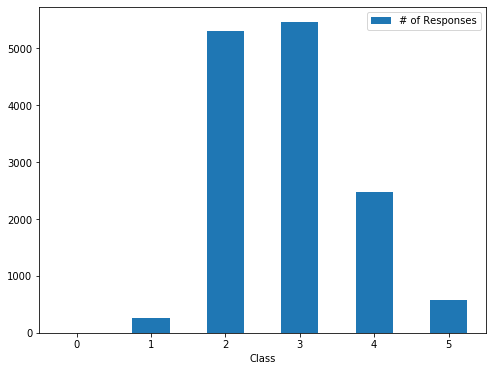

In [0]:
# make value_counts dataframe, sort index (i.e. Class)
value_counts_df = pd.DataFrame(new_df['Class'].value_counts().sort_index())

# rename column
value_counts_df = value_counts_df.rename(columns={'Class': '# of Responses'})

# rename index
value_counts_df.index.name = 'Class'

# bar plot of Class value counts (0 rotation of Class labels)
value_counts_df.plot.bar(rot=0, figsize=(8, 6));

Let's compare the average Word_Count of each Class. We can see that Class 0 has by far the highest word count. Again, it looks like the questionnaire was copy-pasted in for a response for Class 0. Besides Class 0, the plot shows a steady increase in word count from one class to the next.

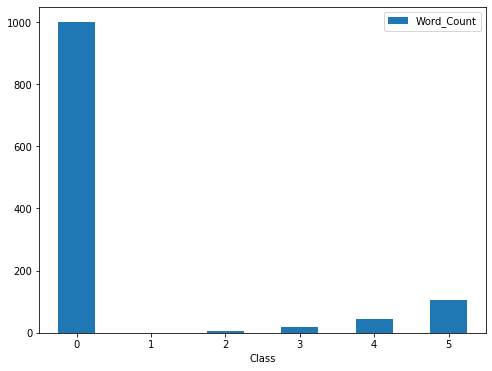

In [0]:
# make word count dataframe
word_count_df = pd.DataFrame(pd.DataFrame(new_df.groupby(['Class'])['Word_Count'].mean()))

# bar plot of Class word counts (0 rotation of Class labels)
word_count_df.plot.bar(rot=0, figsize=(8, 6));

Now let's look at Word_Count_Cleaned averages. We see similar results but less words overall, which is expected.

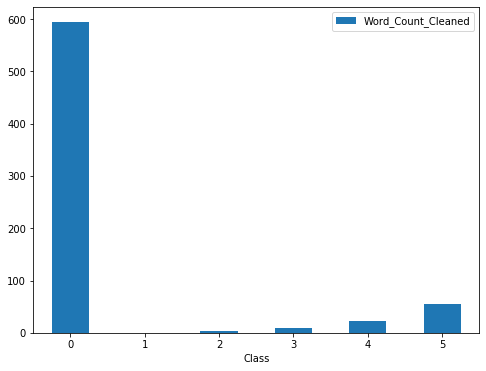

In [0]:
# make word count cleaned dataframe
word_count_clean_df = pd.DataFrame(pd.DataFrame(new_df.groupby(['Class'])['Word_Count_Cleaned'].mean()))

# bar plot of Class word counts cleaned (0 rotation of Class labels)
word_count_clean_df.plot.bar(rot=0, figsize=(8, 6));

We'll skip the Miscomprehension_Pct variable because the Unintelligible_Response variable is more informative. Let's look at what percent of responses are unintelligible. Again, all the unintelligible responses are in Class 1. Less than 2% of the responses were gibberish.

In [0]:
# get value counts of unint responses, normalize to see percent
new_df['Unintelligible_Response'].value_counts(normalize=True)

False    0.981139
True     0.018861
Name: Unintelligible_Response, dtype: float64

Now let's look at the Flesch_Kincaid_Grade averages by class. We see the outlier is very high because it was likely copied from a professional document. Then the grade increases steadily from class to class. You will also notice that Class 1 is negative. Because the way this metric is calculated and because there are essentially no words in the unintelligible class, the grade turns negative. See Flesch Kincaid link above for more information.

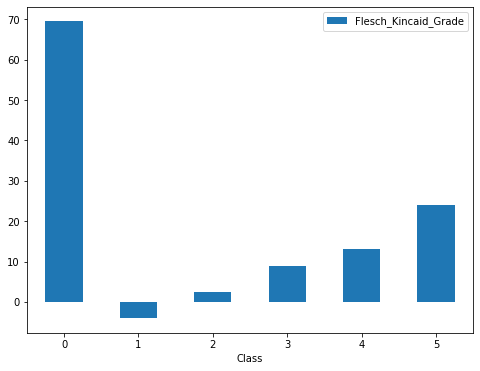

In [0]:
# make Flesch_Kincaid_Grade averages dataframe
fk_grade_df = pd.DataFrame(pd.DataFrame(new_df.groupby(['Class'])['Flesch_Kincaid_Grade'].mean()))

# bar plot of Class word counts cleaned (0 rotation of Class labels)
fk_grade_df.plot.bar(rot=0, figsize=(8, 6));

Let's now look at Flesch_Reading_Ease average by class. Except for the outliers, as the classes get higher, the reading ease gets lower. This indicates more complexity in the higher-class responses. Intuitively, this is what we would expect. The negative value for the outliers is due to the way the metric is calculated. Please refer to the Flesch Kincaid link above for more information.

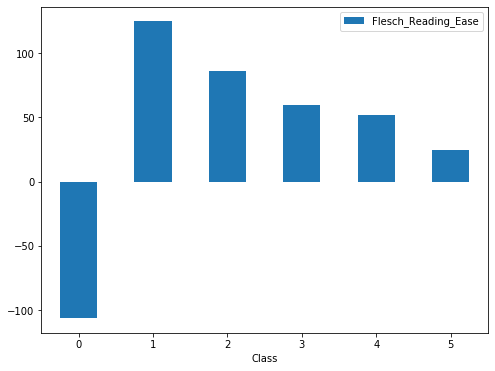

In [0]:
# make word count cleaned dataframe
word_count_df = pd.DataFrame(pd.DataFrame(new_df.groupby(['Class'])['Flesch_Reading_Ease'].mean()))

# bar plot of Class word counts cleaned (0 rotation of Class labels)
word_count_df.plot.bar(rot=0, figsize=(8, 6));

Let's look at some samples from each class.

In [0]:
# class 0 sample -- all these responses were the same, so I will only show one sample
new_df[new_df['Class'] == 0].head(1)

In [0]:
# class 2 sample
new_df[new_df['Class'] == 2].sample(5)

In [0]:
# class 3 sample
new_df[new_df['Class'] == 3].sample(5)

In [0]:
# class 4 sample
new_df[new_df['Class'] == 4].sample(5)

In [0]:
# class 5 sample
new_df[new_df['Class'] == 5].sample(5)

## Notes on Analysis:

From basic analysis, we see that the clustering algoritms combined with human intuition have given us distinct classes that help us understand the complexity of the responses.

One could assume that more complex responses indicate a better understanding of the training material. But that is still only an assumption. More complex responses could also indicate more patience in filling out questionnaires. More complex responses could alsa indicate more job experience. Respondents new on the job indicated they had less to say. They have not experienced enough to answer definitively.

I believe further data collection and analysis would help us better answer the question:
"How much did the respondents learn from the online course?"

I will discuss suggestions in the Notes section below.

# Predictive Modeling

In this section we will develop a machine learning model to automatically classify responses in the future. We will also learn which variables are most impactful on the model's predictive ability. The variable (feature) importances will help us learn more about the data as well.

First, we'll again use the tfidf_words function from above to vectorize the responses (i.e. turn number into words).

In [0]:
# apply function -- change null values to string for model
new_df = tfidf_words(new_df.fillna('NaN'))

Below we separate the data into independent and dependent variables (X and y). The y variable is the Class and what we want to predict. The X variables are what we will use to make the predictions.

In [0]:
# make X variable -- exclude text data that the model will reject and Class
X = new_df.drop(columns=['Response', 'Response_Cleaned', 'Class'])

# make y variable with Class
y = new_df['Class']

Now we'll split the data into train and test datasets. We will fit the data to train and see if our models predictive ability with test. The test dataset will be 33% of our original dataset.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

Below we'll create the model instance, fit the data to the model and get our accuracy score (i.e. how many predictions were correct). The accuracy indicates what percentage of correct predictions the model could make on data (test data) it hasn't seen before. The accuracy is over 90%!

For a more in-depth look at the Logistic Regression model, check out this very informative article:

https://towardsdatascience.com/logistic-regression-for-dummies-a-detailed-explanation-9597f76edf46

#### Note: The cell below will take quite a while to run (15-20 minutes). We can speed up this process if we serialize the model. Please let me know if you're interested in taking that step.

In [0]:
# make logistic regression instance
lr = LogisticRegression(solver='lbfgs', max_iter=3000, multi_class='auto')

# fit training data
lr.fit(X_train, y_train)

# predict test data
y_pred = lr.predict(X_test)

# get accuracy score
acc_score = accuracy_score(y_test, y_pred)

# print score
print('Model Accuracy: {}%'.format(str(acc_score * 100)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



Model Accuracy: 91.29780833691449%


Let's see how accurate the predictions were by class.

In [0]:
# make dataframe with classes and predicted classes
pred_data = {'Class': y_test, 'Predicted_Class': list(y_pred)}
pred_df = pd.DataFrame(data=pred_data)

# loop to check if class equals predicted class, store 1 if true, 0 if false
pred_true = []
for c, pc in zip(pred_df['Class'].tolist(), pred_df['Predicted_Class'].tolist()):
  if c == pc:
    pred_true.append(1)
  else:
    pred_true.append(0)

# make new predictions true column in dataframe
pred_df['Predictions_True'] = pred_true

# count all true predictions by class
acc_predictions = pd.DataFrame(pred_df.groupby(['Class'])['Predictions_True'].sum())

# count class totals
class_totals = pd.DataFrame(pred_df['Class'].value_counts().sort_index())

# divide number of true predictions by class totals
acc_predictions['Accuracy_by_Class'] = test1['Predictions_True'] / test2['Class']

# show results
acc_predictions.drop(columns=['Predictions_True'])

,Accuracy_by_Class
Class,
0,0.666667
1,1.000000
2,0.940257
3,0.891292
4,0.882283
5,0.962766


The model was worst at prediction the outlier. However, there were only 3 outliers in the test dataset, and 2 were predicted correctly.

# Notes

The current results of the project make the assumption that more complex responses indicate a greater knowledge of the online training materials. As discussed in the Analysis section, this assumption may have drawbacks. 

To better answer the question "How much did the respondents learn from the online course?" There may be extra steps to take. I think the best route would be asking another follow up question or two in the questionnare. 

For example, you could ask:"How did the online course help you? If the course did not help you, why?"

Another option would be asking a broad question like: "How do you feel about the online course?" This would allow the respondent to speak freely and encourage them to provide sentiment data (e.g. "I like it because...", "I don't like it because..."

I also think it would be beneficial to add more context to the data if possible. For example, how long the worker has been employed, what role they're in, a job performance metric, etc. Of course, it would be imperative that the data be anonymized.

It also might be beneficial to dig deeper into the data we already have. I refrained on deeper analysis for now because of time constraints.

Thank you. I look forward to hearing your feedback.